# MATH70110 Quantitative Risk Management
Imperial College London <br>
MSc in Mathematics and Finance  <br>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import scipy.stats as stats
from scipy.stats import genpareto, norm, t

In [4]:
data = pd.read_csv("QRM-2025-cw2-data.csv", parse_dates=["Date"], index_col="Date")
display(data)

,TSLA
Date,
2012-11-26,2.151333
2012-11-27,2.143333
2012-11-28,2.215333
2012-11-29,2.246000
2012-11-30,2.254667
...,...
2022-11-18,180.190002
2022-11-21,167.869995
2022-11-22,169.910004


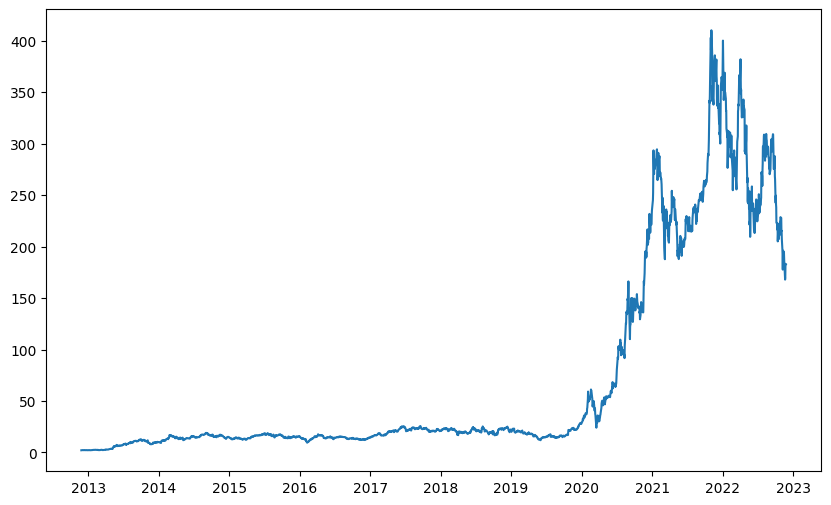

In [5]:
plt.figure(figsize=(10,6))
plt.plot(data["TSLA"])
plt.show()

In [6]:
data["log_return"] = 100 * np.log(data["TSLA"] / data["TSLA"].shift(1))
data = data.dropna()
data["loss"] = -data["log_return"]

split_date = "2021-11-26"

train_data = data.loc[data.index < split_date, "loss"]
test_data = data.loc[data.index >= split_date, "loss"]

In [7]:
model = arch_model(train_data, mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
# res = model.fit(update_freq=5)
res = model.fit()
res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.56135608937
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.9481359222045
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970781705604
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.872356112031
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501716342509
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248079330559
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.800075139419
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.346350847171
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.9092544727755
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.9091196140935
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.909118900292
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.909118900292
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   loss   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5854.91
Distribution:                  Normal   AIC:                           11717.8
Method:            Maximum Likelihood   BIC:                           11740.7
                                        No. Observations:                 2266
Date:                Thu, Dec 04 2025   Df Residuals:                     2265
Time:                        13:27:42   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu            -0.1506  6.417e-02     -2.347  1.891e-02 [ -0.2

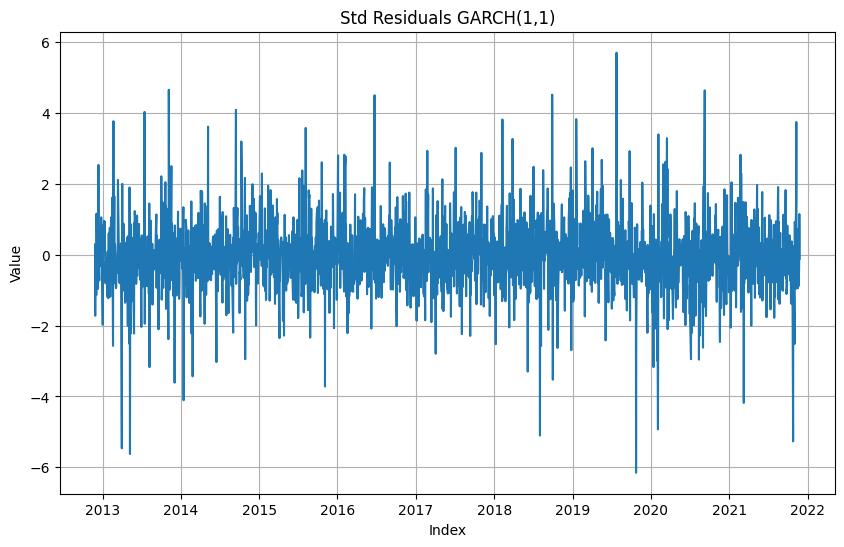

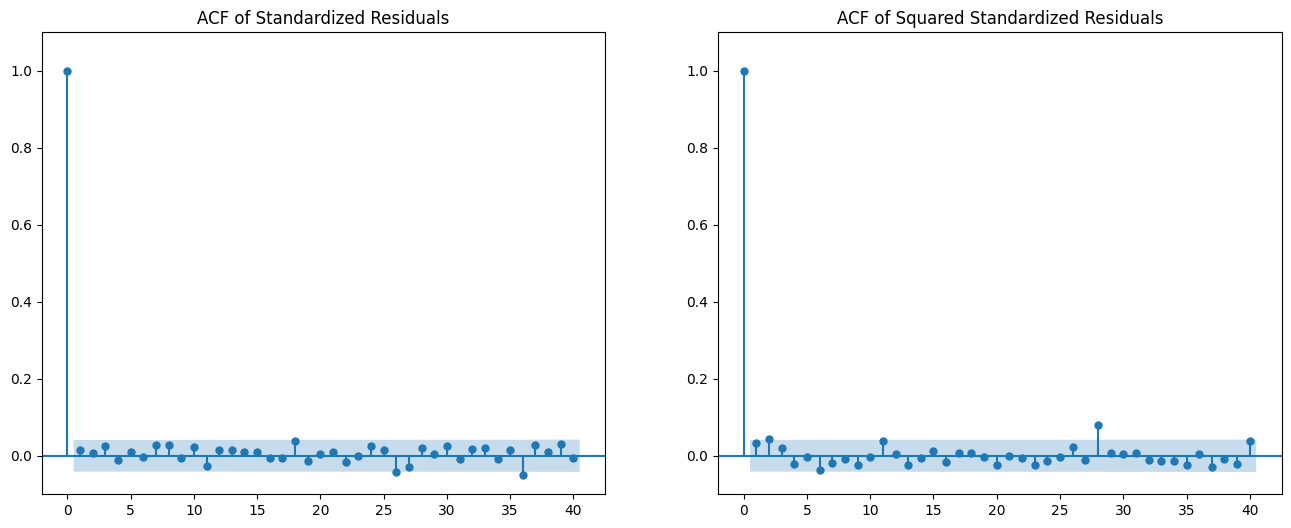

In [8]:
std_resid = res.std_resid

plt.figure(figsize=(10, 6))
plt.plot(train_data.index, std_resid)
plt.title('Std Residuals GARCH(1,1)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# acf for std residuals
plot_acf(std_resid, lags=40, ax=ax[0], title='ACF of Standardized Residuals')
ax[0].set_ylim(-0.1, 1.1)
# acf for squared std residuals, maybe this is useless
plot_acf(std_resid**2, lags=40, ax=ax[1], title='ACF of Squared Standardized Residuals')

ax[1].set_ylim(-0.1, 1.1)
plt.show()

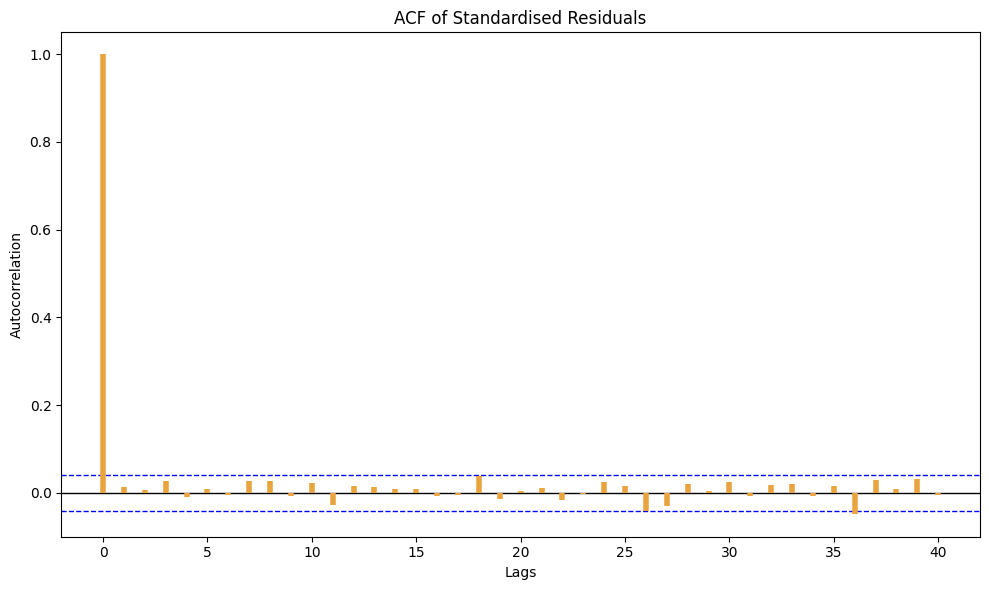

In [9]:
def plot_acf_lines(ax, lags, acf_vals, title, band, orange):
    """
    Custom function to plot ACF with specified line styles and colors.
    """
    # Horizontal axis lines and Confidence Interval (CF)
    ax.axhline(0.0, color="black", linewidth=1.0)   # y=0 line
    ax.axhline(band, color="blue", linestyle="--", linewidth=1.0)   # upper CF line
    ax.axhline(-band, color="blue", linestyle="--", linewidth=1.0)  # lower CF line

    # Bar chart bars
    ax.vlines(lags, 0.0, acf_vals, colors=orange, linewidth=4.0)
    ax.set_title(title)
    ax.set_ylabel("Autocorrelation")
    ax.set_xlabel("Lags")
    ax.set_xlim(-2, lags.max()+2)    # +-2 on both sides so that leftmost and rightmost bars arent cut off
    ax.set_ylim(min(-0.1, acf_vals.min()-0.05), 1.05)
    #ax.grid(True, axis='y', linestyle='--', alpha=0.6) # Added grid for readability

max_lags = 40
orange_color = '#E9A440' # The specific orange/amber hex code

# Calculate the ACF values and Confidence Intervals (confint)
# alpha=0.05 sets the 95% confidence level
acf_vals, confint = acf(std_resid, nlags=max_lags, alpha=0.05, fft=False)

# The 'band' is the value of the critical line (the distance from 0)
# We calculate it as the upper bound of the first non-zero lag (lag 1)
band = confint[1, 1] - acf_vals[1]

# Create the lags array (x-axis)
lags = np.arange(len(acf_vals))


# --- 3. Plotting using the custom function ---

fig, ax = plt.subplots(figsize=(10, 6))

plot_acf_lines(
    ax=ax,
    lags=lags,
    acf_vals=acf_vals,
    title='ACF of Standardised Residuals',
    band=band,
    orange=orange_color
)

plt.tight_layout()
plt.show()

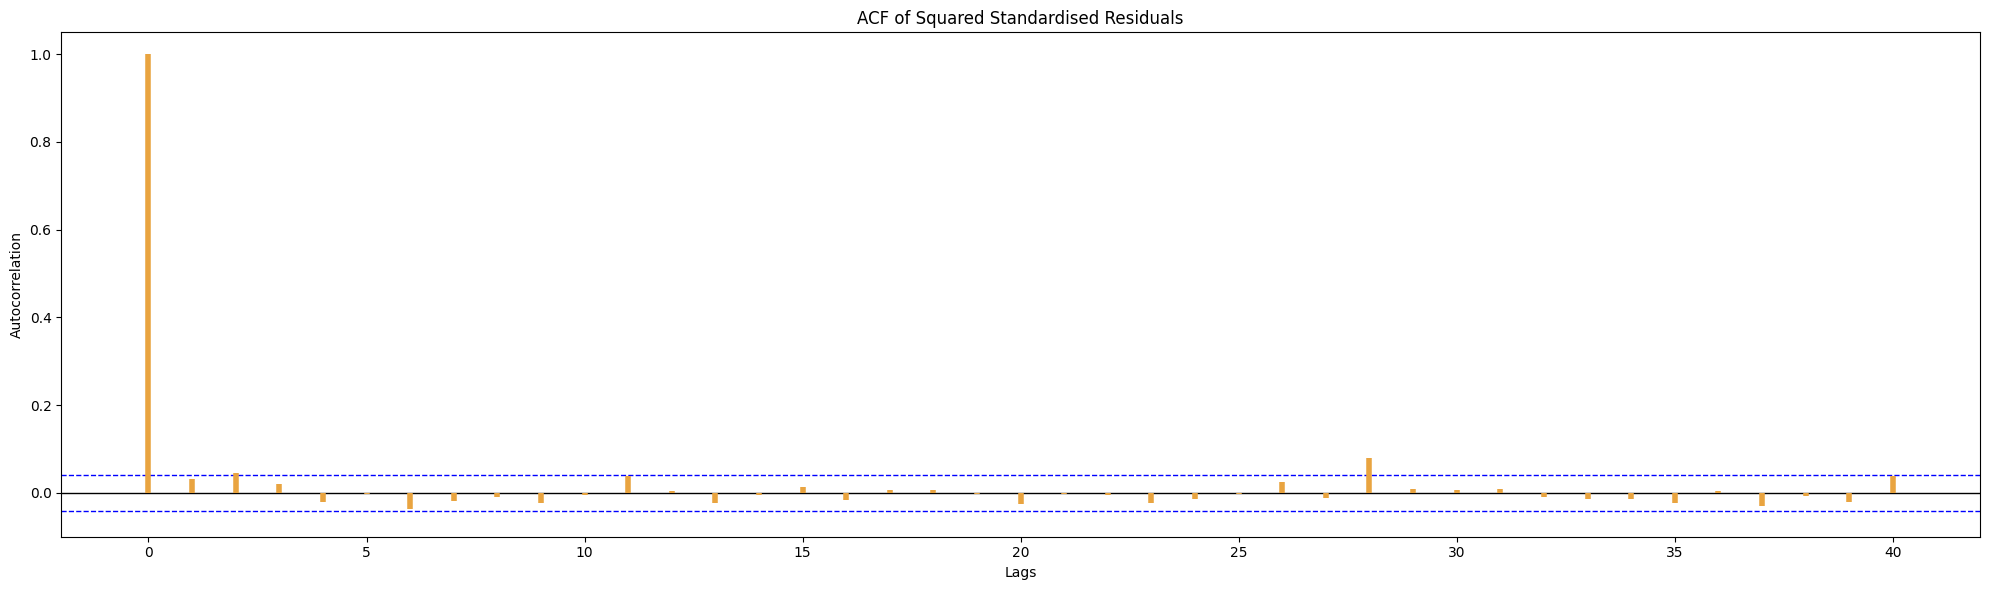

In [10]:
def plot_acf_lines(ax, lags, acf_vals, title, band, orange):
    """
    Custom function to plot ACF with specified line styles and colors.
    """
    # Horizontal axis lines and Confidence Interval (CF)
    ax.axhline(0.0, color="black", linewidth=1.0)   # y=0 line
    ax.axhline(band, color="blue", linestyle="--", linewidth=1.0)   # upper CF line
    ax.axhline(-band, color="blue", linestyle="--", linewidth=1.0)  # lower CF line

    # Bar chart bars
    ax.vlines(lags, 0.0, acf_vals, colors=orange, linewidth=4.0)
    ax.set_title(title)
    ax.set_ylabel("Autocorrelation")
    ax.set_xlabel("Lags")
    ax.set_xlim(-2, lags.max()+2)    # +-2 on both sides so that leftmost and rightmost bars arent cut off
    ax.set_ylim(min(-0.1, acf_vals.min()-0.05), 1.05)
    #ax.grid(True, axis='y', linestyle='--', alpha=0.6) # Added grid for readability

max_lags = 40
orange_color = '#E9A440' # The specific orange/amber hex code

# Calculate the ACF values and Confidence Intervals (confint)
# alpha=0.05 sets the 95% confidence level
acf_vals, confint = acf(std_resid**2, nlags=max_lags, alpha=0.05, fft=False)

# The 'band' is the value of the critical line (the distance from 0)
# We calculate it as the upper bound of the first non-zero lag (lag 1)
band = confint[1, 1] - acf_vals[1]

# Create the lags array (x-axis)
lags = np.arange(len(acf_vals))


# --- 3. Plotting using the custom function ---

fig, ax = plt.subplots(figsize=(20, 6))

plot_acf_lines(
    ax=ax,
    lags=lags,
    acf_vals=acf_vals,
    title='ACF of Squared Standardised Residuals',
    band=band,
    orange=orange_color
)

plt.tight_layout()
plt.show()

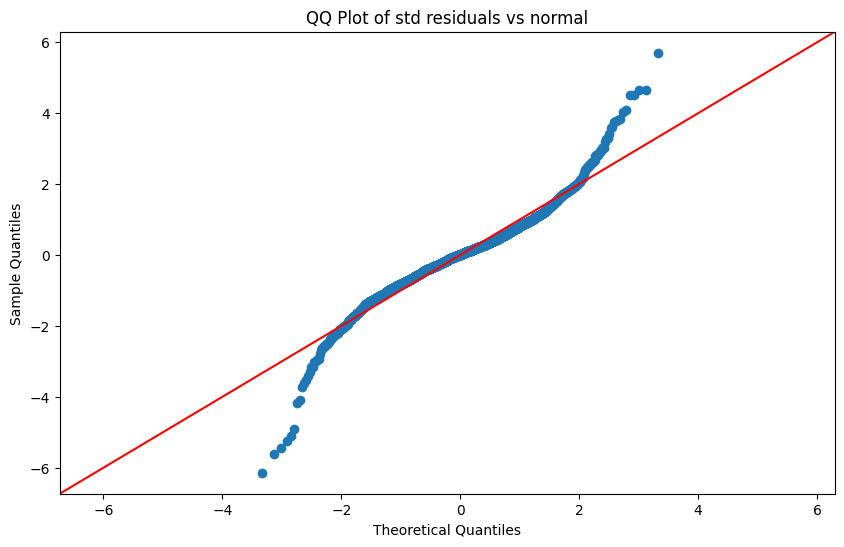

In [11]:
fig = sm.qqplot(
    std_resid,
    line='45',
    fit=True
)

# 2. Use the returned figure object to set the size.
fig.set_size_inches(10, 6)

plt.title('QQ Plot of std residuals vs normal')
plt.show()

Fitted Student-t Parameters:
Degrees of Freedom (nu): 3.5601
Location (Mean):         -0.0142
Scale:                   0.6859


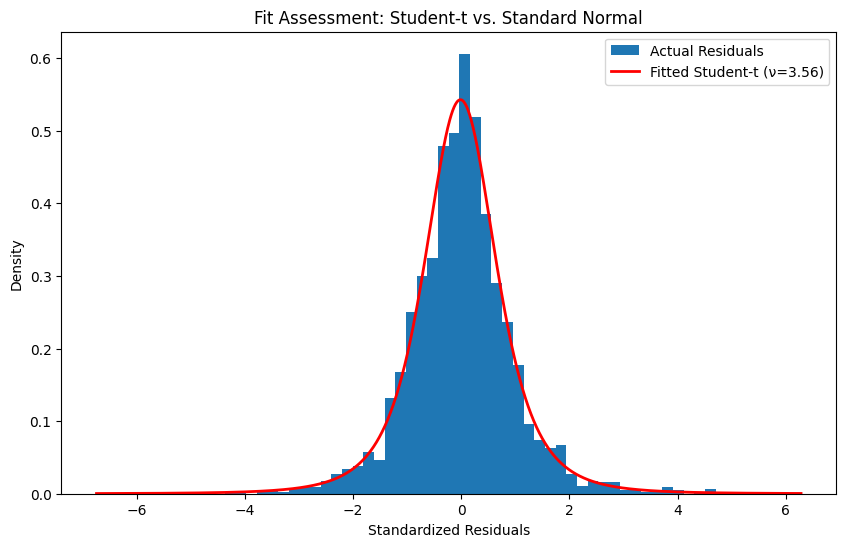

In [12]:
nu, loc, scale = stats.t.fit(std_resid)

print("Fitted Student-t Parameters:")
print(f"Degrees of Freedom (nu): {nu:.4f}")
print(f"Location (Mean):         {loc:.4f}")
print(f"Scale:                   {scale:.4f}")


plt.figure(figsize=(10, 6))
plt.hist(std_resid, bins=60, density=True, alpha=1, label='Actual Residuals')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)

pdf_t = stats.t.pdf(x, nu, loc, scale)
plt.plot(x, pdf_t, 'r-', linewidth=2, label=f'Fitted Student-t (ν={nu:.2f})')

pdf_norm = stats.norm.pdf(x, 0, 1)
#plt.plot(x, pdf_norm, 'k--', linewidth=1.5, label='Standard Normal')

plt.title('Fit Assessment: Student-t vs. Standard Normal')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
# plt.grid(True, alpha=0.3)
plt.show()

/Users/lucawurker/Desktop/QRM Project 2/.venv/lib/python3.13/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


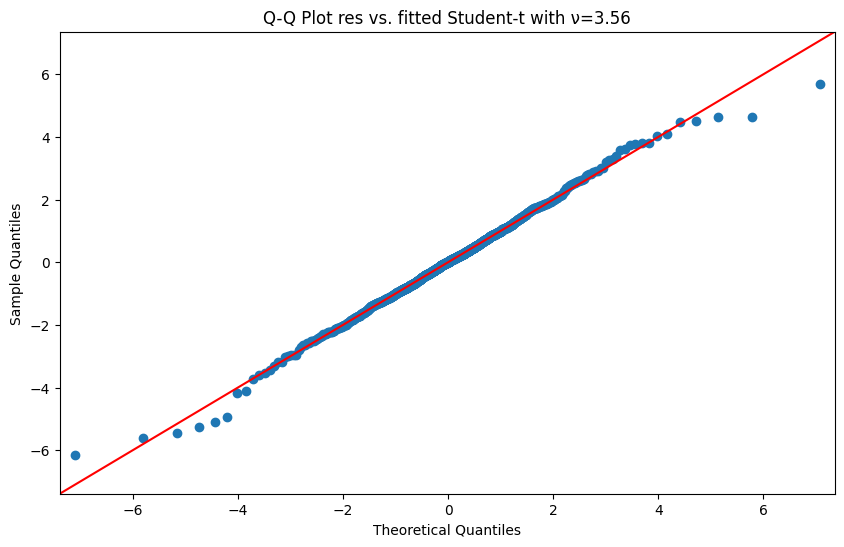

In [13]:
fig = sm.qqplot(std_resid, dist=stats.t, color="blue", distargs=(nu,), loc=loc, scale=scale, line='45', fit=False)
fig.set_size_inches(10, 6)
plt.title(f'Q-Q Plot res vs. fitted Student-t with ν={nu:.2f}')
# plt.grid(True, alpha=0.5)
plt.show()


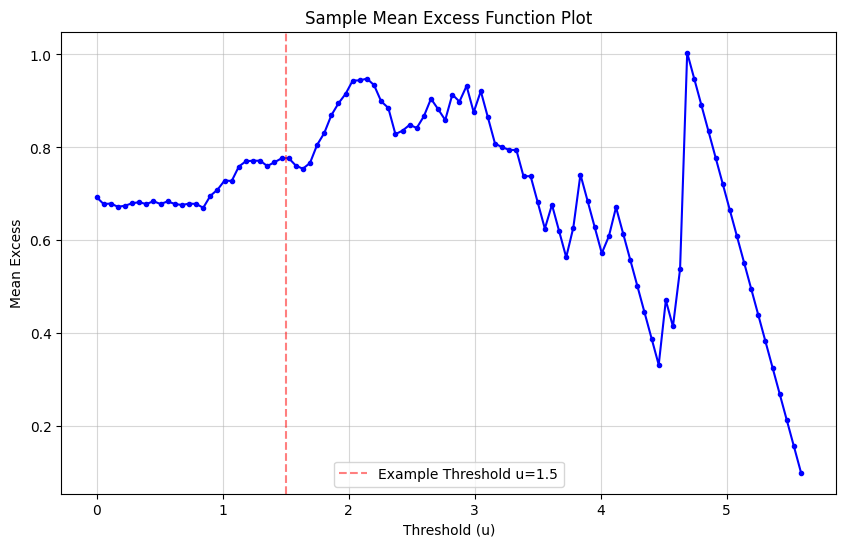

In [19]:
data = np.array(std_resid).flatten()

def mean_excess_function(data, thresholds):
    mean_excess = []
    for u in thresholds:
        # Get data points above threshold u
        excesses = data[data > u] - u
        if len(excesses) > 0:
            mean_excess.append(np.mean(excesses))
        else:
            mean_excess.append(np.nan)
    return np.array(mean_excess)


thresholds = np.linspace(np.percentile(data, 50), np.max(data) - 0.1, 100)
mef_values = mean_excess_function(data, thresholds)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, mef_values, 'b.-')
plt.title('Sample Mean Excess Function Plot')
plt.xlabel('Threshold (u)')
plt.ylabel('Mean Excess')
plt.grid(True, alpha=0.5)
#plt.xlim(0,2.2)
#plt.ylim(0.5,1.0)

plt.axvline(x=1.5, color='r', linestyle='--', alpha=0.5, label='Example Threshold u=1.5')
plt.legend()
plt.show()

Chosen threshold u: 0.8
Number of exceedances: 357
Exceedance rate: 15.75%
Shape (xi):  0.1380
Scale (sigma): 0.5834


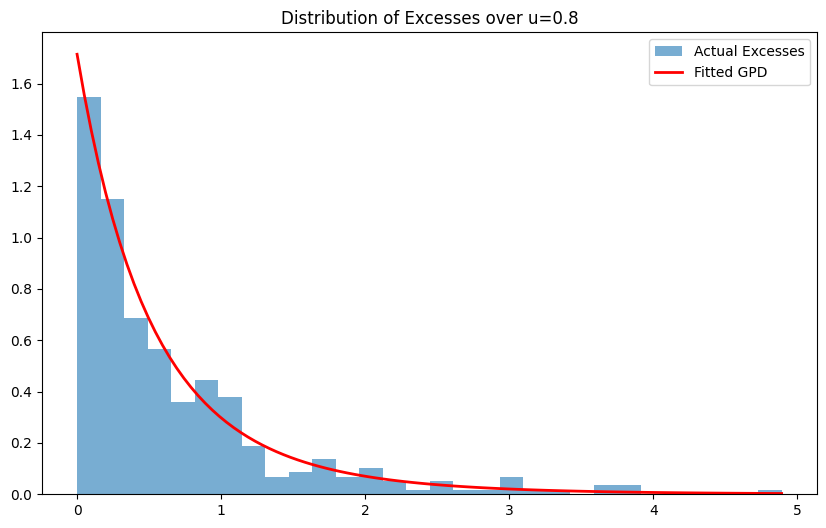

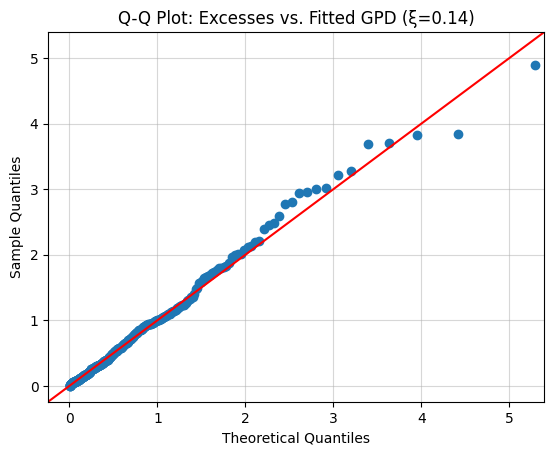

In [20]:
u = 0.8

excesses = data[data > u] - u
n_exceedances = len(excesses)

print(f"Chosen threshold u: {u}")
print(f"Number of exceedances: {n_exceedances}")
print(f"Exceedance rate: {n_exceedances / len(data):.2%}")

shape_xi, loc_param, scale_sigma = genpareto.fit(excesses, floc=0)

print(f"Shape (xi):  {shape_xi:.4f}")
print(f"Scale (sigma): {scale_sigma:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(excesses, bins=30, density=True, alpha=0.6, label='Actual Excesses')

x_space = np.linspace(0, max(excesses), 100)
pdf_gpd = genpareto.pdf(x_space, shape_xi, loc=0, scale=scale_sigma)
plt.plot(x_space, pdf_gpd, 'r-', linewidth=2, label='Fitted GPD')

plt.title(f'Distribution of Excesses over u={u}')
plt.legend()
plt.show()

fig = sm.qqplot(excesses, dist=genpareto, distargs=(shape_xi,), loc=0, scale=scale_sigma, line='45', fit=False)
plt.title(f'Q-Q Plot: Excesses vs. Fitted GPD (ξ={shape_xi:.2f})')
plt.grid(True, alpha=0.5)
plt.show()

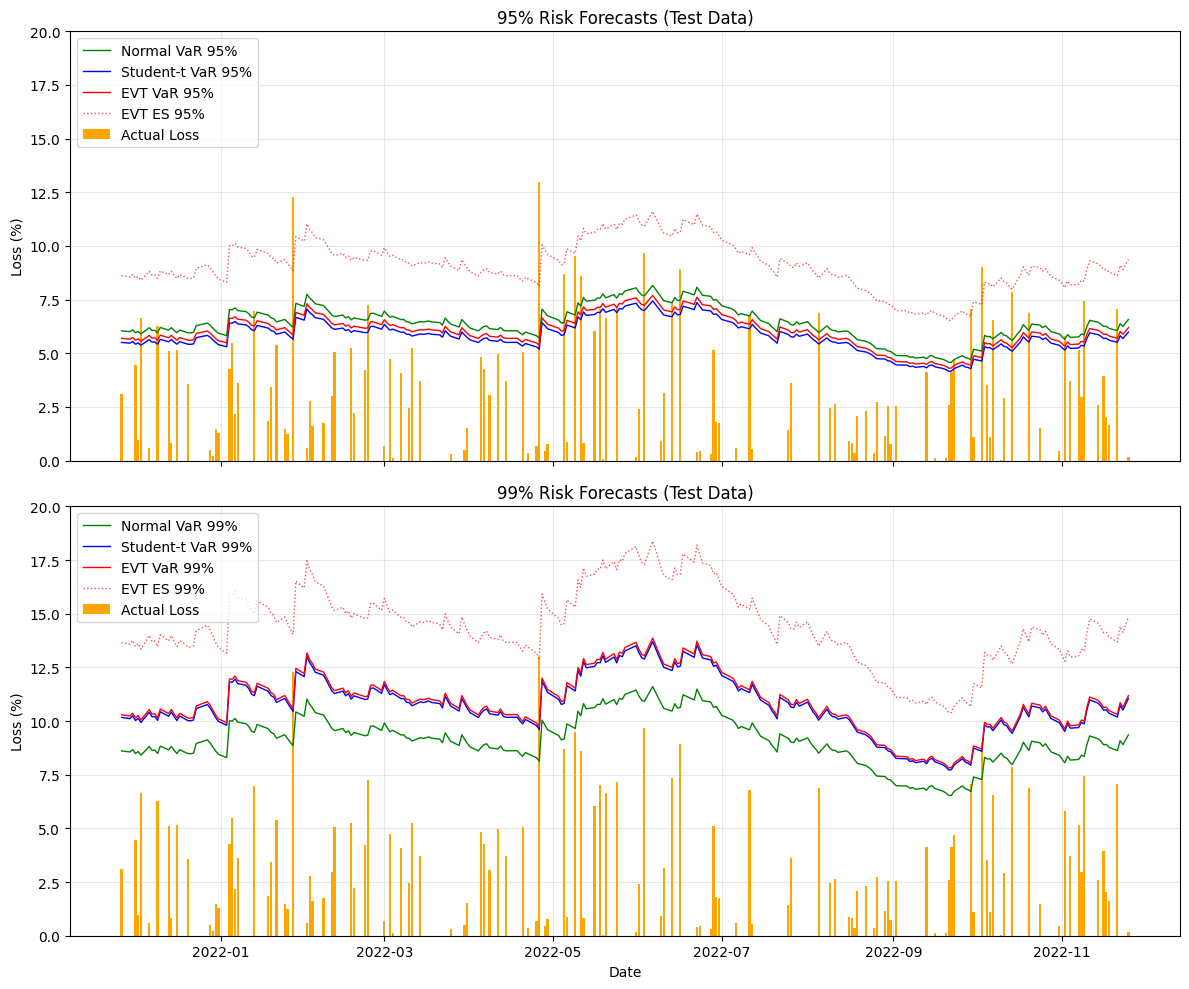

Model           | Alpha | Violations | Rate (%) | LR Stat  | P-Value  | Result    
------------------------------------------------------------------------------------------
Norm            | 0.95  | 22         | 8.73     | 6.10     | 0.0135   | Reject    
t               | 0.95  | 25         | 9.92     | 10.11    | 0.0015   | Reject    
EVT             | 0.95  | 24         | 9.52     | 8.68     | 0.0032   | Reject    
------------------------------------------------------------------------------------------
Norm            | 0.99  | 4          | 1.59     | 0.75     | 0.3880   | Accept    
t               | 0.99  | 3          | 1.19     | 0.09     | 0.7680   | Accept    
EVT             | 0.99  | 3          | 1.19     | 0.09     | 0.7680   | Accept    
------------------------------------------------------------------------------------------


In [31]:
data = pd.read_csv("QRM-2025-cw2-data.csv", parse_dates=["Date"], index_col="Date")
data["log_return"] = 100 * np.log(data["TSLA"] / data["TSLA"].shift(1))
data = data.dropna()
data["loss"] = -data["log_return"]

split_date = "2021-11-26"

loss_train = data.loc[data.index < split_date, "loss"]
loss_test = data.loc[data.index >= split_date, "loss"]

# 🛠️ FIX: Assign the index of the test data (loss_test) for plotting the test period
dates_test = loss_test.index

# 2. Fit GARCH(1,1) on TRAINING Data Only
# ==========================================
# Define model on training data to estimate parameters
model_train = arch_model(loss_train, mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
res_train = model_train.fit(disp='off')

# Extract standardized residuals from training for fitting t and EVT distributions
std_resid_train = res_train.std_resid.dropna()

# 3. Forecast Volatility for TEST Data
# ==========================================
# CRITICAL STEP: Create a new model using the FULL dataset
model_full = arch_model(data['loss'], mean='Constant', vol='Garch', p=1, q=1, dist='Normal')

# Apply the parameters estimated from the TRAINING set to the FULL set
# This filters the full history to generate conditional volatility for the test period
fixed_res = model_full.fix(res_train.params)

# Extract conditional volatility (sigma) only for the test period
# Note: fixed_res.conditional_volatility contains sigma for ALL dates, we only need the test dates
sigma_test = fixed_res.conditional_volatility.loc[data.index >= split_date]
mu_test = fixed_res.params['mu']

# 4. Calculate Quantiles (VaR_Z) and ES_Z for the Noise Z
# ==========================================
alphas = [0.95, 0.99]

# A. Standard Normal
norm_risk = {}
for alpha in alphas:
    q = norm.ppf(alpha)
    es = norm.pdf(q) / (1 - alpha)
    norm_risk[alpha] = {'VaR_Z': q, 'ES_Z': es}

# B. Normalized Student-t
# Fit t-distribution to standardized training residuals
nu_fit, t_loc, t_scale = t.fit(std_resid_train)

t_risk = {}
for alpha in alphas:
    q = t.ppf(alpha, df=nu_fit, loc=t_loc, scale=t_scale)
    # Calculate ES via numerical integration
    # Note: Using t.expect can be slow/unstable; an analytical formula for standardized t-dist exists,
    # but the current approach attempts to handle the fitted non-standardized t-dist.
    tail_expect = t.expect(lambda x: x, args=(nu_fit,), loc=t_loc, scale=t_scale, lb=q) / (1-alpha)
    t_risk[alpha] = {'VaR_Z': q, 'ES_Z': tail_expect}

# C. EVT (GPD)
# Fit GPD to excesses over threshold u (using training residuals)
u = 1.5
excesses = std_resid_train[std_resid_train > u] - u
# Note: genpareto.fit uses floc=0 to fix the location parameter to zero, as required by the theory.
xi_hat, _, beta_hat = genpareto.fit(excesses, floc=0)

N = len(std_resid_train)
Nu = len(excesses)

evt_risk = {}
for alpha in alphas:
    # Analytical VaR and ES formulas for GPD (Extreme Value Theory)
    term = ((1 - alpha) / (Nu / N)) ** (-xi_hat) - 1
    var_z = u + (beta_hat / xi_hat) * term
    es_z = (var_z + beta_hat - xi_hat * u) / (1 - xi_hat)
    
    evt_risk[alpha] = {'VaR_Z': var_z, 'ES_Z': es_z}

# 5. Compute Dynamic VaR and ES for Test Set
# ==========================================
results = {0.95: {}, 0.99: {}}

for alpha in alphas:
    # Normal
    results[alpha]['Norm_VaR'] = mu_test + sigma_test * norm_risk[alpha]['VaR_Z']
    results[alpha]['Norm_ES']  = mu_test + sigma_test * norm_risk[alpha]['ES_Z']
    
    # Student-t
    results[alpha]['t_VaR'] = mu_test + sigma_test * t_risk[alpha]['VaR_Z']
    results[alpha]['t_ES']  = mu_test + sigma_test * t_risk[alpha]['ES_Z']
    
    # EVT
    results[alpha]['EVT_VaR'] = mu_test + sigma_test * evt_risk[alpha]['VaR_Z']
    results[alpha]['EVT_ES']  = mu_test + sigma_test * evt_risk[alpha]['ES_Z']

# 6. Plotting Results
# ==========================================
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for 95%
ax[0].bar(dates_test, loss_test, label='Actual Loss', color="orange")
ax[0].plot(dates_test, results[0.95]['Norm_VaR'], 'g-', label='Normal VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['t_VaR'], 'b-', label='Student-t VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['EVT_VaR'], 'r-', label='EVT VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['EVT_ES'], 'r:', label='EVT ES 95%', linewidth=1, alpha=0.7)
ax[0].set_title('95% Risk Forecasts (Test Data)')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Loss (%)')
ax[0].grid(True, alpha=0.3)
ax[0].set_ylim(0,20)

# Plot for 99%
ax[1].bar(dates_test, loss_test, label='Actual Loss', color="orange")
ax[1].plot(dates_test, results[0.99]['Norm_VaR'], 'g-', label='Normal VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['t_VaR'], 'b-', label='Student-t VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['EVT_VaR'], 'r-', label='EVT VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['EVT_ES'], 'r:', label='EVT ES 99%', linewidth=1, alpha=0.7)
ax[1].set_title('99% Risk Forecasts (Test Data)')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Loss (%)')
ax[1].grid(True, alpha=0.3)
ax[1].set_ylim(0,20)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 7. Unconditional Coverage Backtest (Kupiec's Test)
# ==========================================
def kupiec_test(actual, var_forecast, alpha):
    T = len(actual)
    I = (actual > var_forecast).astype(int)
    x = I.sum() 
    p_hat = x / T 
    p = 1 - alpha 
    
    # Handle the case of zero violations which causes log(0)
    if x == 0: 
        ln_L0 = T * np.log(1 - p)
        ln_L1 = T * np.log(1 - p_hat) if p_hat != 1.0 else np.nan # p_hat should be 0 if x=0
        if p_hat == 0:
             # If p_hat is 0 and x is 0, L1 is 1-0 = 1, log(1)=0, so ln_L1=0
             ln_L1 = 0
        else: # This should not happen if x=0 and T>0
             return x, p_hat, np.nan, np.nan

    else:
        ln_L0 = (T - x) * np.log(1 - p) + x * np.log(p)
        ln_L1 = (T - x) * np.log(1 - p_hat) + x * np.log(p_hat)
        
    LR = -2 * (ln_L0 - ln_L1)
    p_value = 1 - stats.chi2.cdf(LR, 1) if not np.isnan(LR) else np.nan
    
    return x, p_hat, LR, p_value

print(f"{'Model':<15} | {'Alpha':<5} | {'Violations':<10} | {'Rate (%)':<8} | {'LR Stat':<8} | {'P-Value':<8} | {'Result':<10}")
print("-" * 90)

models = ['Norm', 't', 'EVT']
for alpha in alphas:
    for m in models:
        var_col = f"{m}_VaR"
        x, p_hat, lr, p_val = kupiec_test(loss_test, results[alpha][var_col], alpha)
        
        # Display logic for potential NaN or very small p_value
        p_val_str = f"{p_val:<8.4f}" if not np.isnan(p_val) else f"{'NA':<8}"
        lr_str = f"{lr:<8.2f}" if not np.isnan(lr) else f"{'NA':<8}"
        
        if np.isnan(p_val):
             res_str = "Error"
        elif p_val < 0.05:
            res_str = "Reject"
        else:
            res_str = "Accept"
            
        print(f"{m:<15} | {alpha:<5} | {x:<10} | {p_hat*100:<8.2f} | {lr_str} | {p_val_str} | {res_str:<10}")
    print("-" * 90)

Fitting GARCH Model on Training Data...


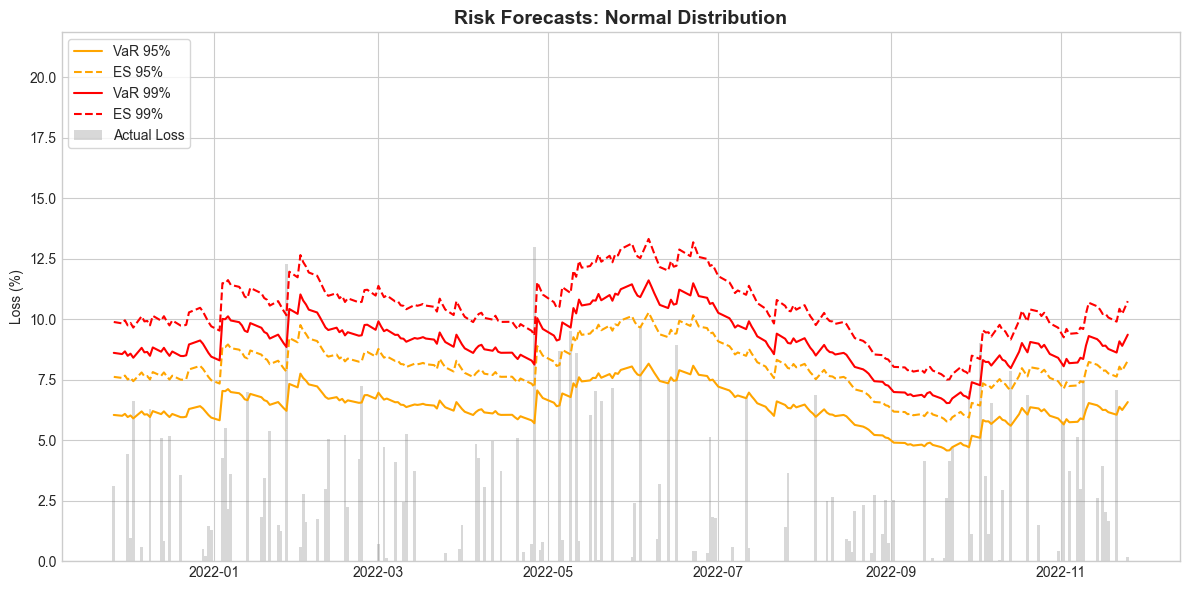

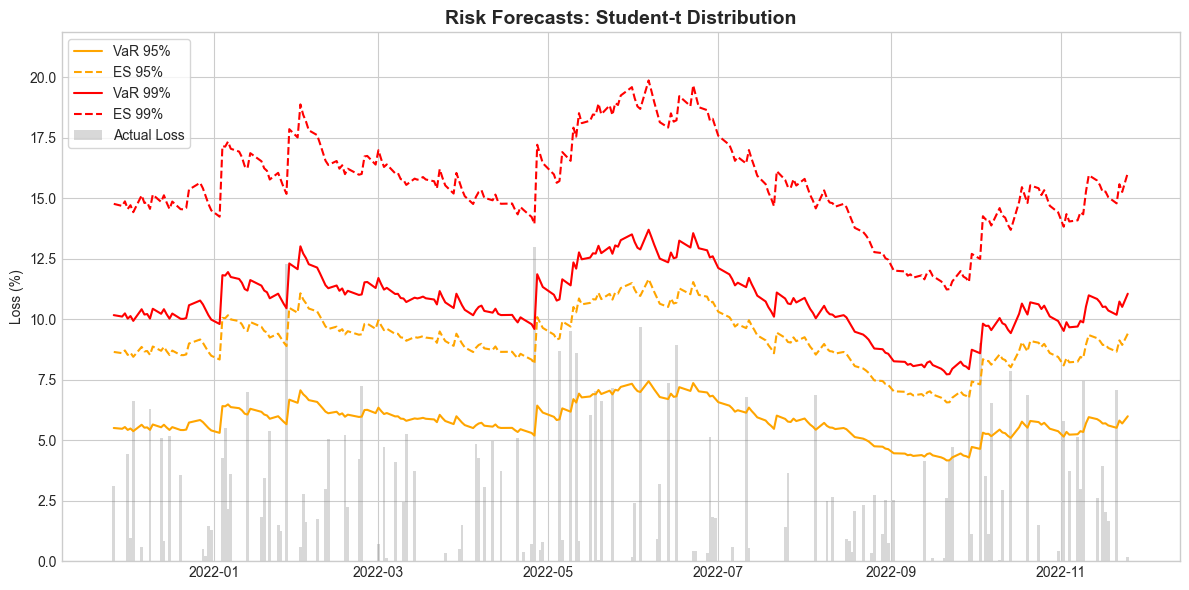

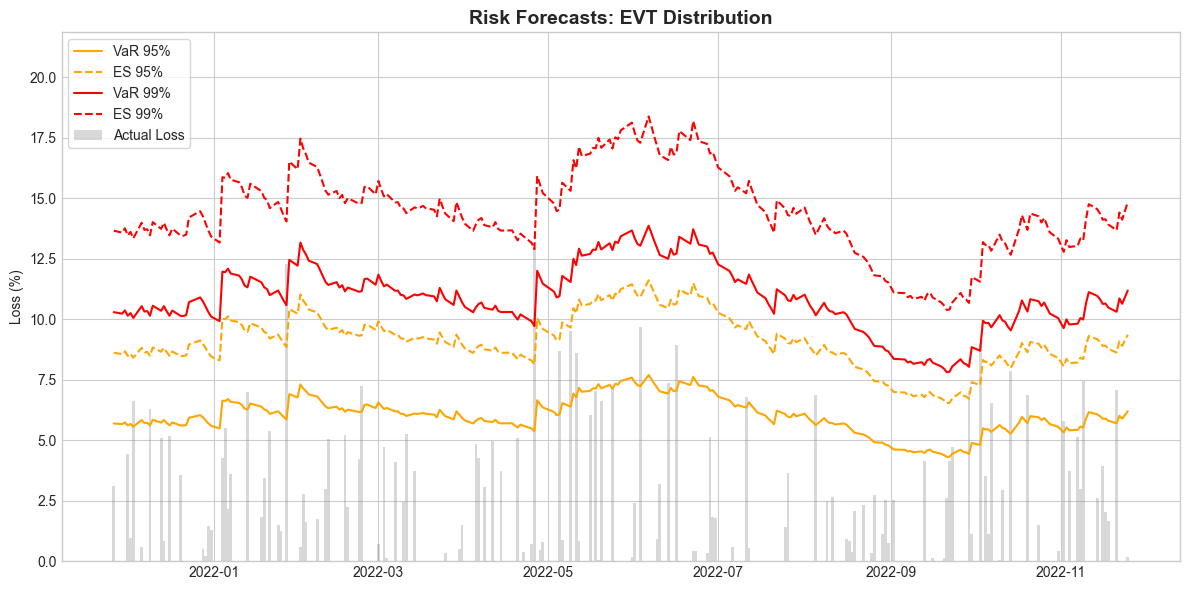


Method       | Alpha | Violations | VaR p-val  | VaR Res  | ES Ratio | ES Diff 
             |       | (Kupiec)   | (>0.05)    |          | (Ideal=1) | (Ideal=0)
----------------------------------------------------------------------------------------------------
Normal       | 0.95  | 22         | 0.0135     | Rej      | 1.0199   | 0.0303  
Student-t    | 0.95  | 25         | 0.0015     | Rej      | 0.8691   | -0.1209 
EVT          | 0.95  | 24         | 0.0032     | Rej      | 0.8839   | -0.1076 
Normal       | 0.99  | 4          | 0.3880     | Acc      | 1.1620   | 0.1480  
Student-t    | 0.99  | 3          | 0.7680     | Acc      | 0.8236   | -0.1796 
EVT          | 0.99  | 3          | 0.7680     | Acc      | 0.8905   | -0.1129 


In [32]:
# Fit GARCH(1,1) on TRAINING Data
print("Fitting GARCH Model on Training Data...")
model_train = arch_model(loss_train, mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
res_train = model_train.fit(disp='off')

# Extract standardized residuals from training (for distribution fitting)
std_resid_train = res_train.std_resid.dropna()

# Forecast Volatility for FULL Data using Training Parameters
model_full = arch_model(data['loss'], mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
fixed_res = model_full.fix(res_train.params)

# Isolate Test Period Statistics
sigma_test = fixed_res.conditional_volatility.loc[data.index >= split_date]
mu_test = fixed_res.params['mu']

# ==========================================
# 2. Risk Dynamics (Z-Scores for VaR & ES)
# ==========================================
alphas = [0.95, 0.99]
risk_params = {0.95: {}, 0.99: {}}

# --- A. Normal Distribution ---
for alpha in alphas:
    q = norm.ppf(alpha)
    es = norm.pdf(q) / (1 - alpha)
    risk_params[alpha]['Normal'] = {'VaR_Z': q, 'ES_Z': es}

# --- B. Student-t Distribution (Analytical) ---
# Fit t-distribution to training residuals
nu, t_loc, t_scale = t.fit(std_resid_train)

for alpha in alphas:
    # VaR (Quantile)
    q = t.ppf(alpha, df=nu, loc=t_loc, scale=t_scale)
    
    # Analytical ES for non-standardized t:
    # First, get standard quantile x_std
    x_std = (q - t_loc) / t_scale
    # Standard ES formula: (nu + x^2) / (nu - 1) * (pdf(x) / (1-alpha))
    es_std = ((nu + x_std**2) / (nu - 1)) * (t.pdf(x_std, df=nu) / (1 - alpha))
    # Rescale
    es_final = t_loc + t_scale * es_std
    
    risk_params[alpha]['Student-t'] = {'VaR_Z': q, 'ES_Z': es_final}

# --- C. EVT (GPD) ---
u = 1.5 # Threshold
excesses = std_resid_train[std_resid_train > u] - u
xi_hat, _, beta_hat = genpareto.fit(excesses, floc=0)
N = len(std_resid_train)
Nu = len(excesses)

for alpha in alphas:
    # VaR
    term = ((1 - alpha) / (Nu / N)) ** (-xi_hat) - 1
    var_z = u + (beta_hat / xi_hat) * term
    # ES
    es_z = (var_z + beta_hat - xi_hat * u) / (1 - xi_hat)
    
    risk_params[alpha]['EVT'] = {'VaR_Z': var_z, 'ES_Z': es_z}

# ==========================================
# 3. Compute Dynamic Risk Estimates
# ==========================================
results = pd.DataFrame(index=dates_test)
results['Actual_Loss'] = loss_test

methods = ['Normal', 'Student-t', 'EVT']

for alpha in alphas:
    for method in methods:
        z_var = risk_params[alpha][method]['VaR_Z']
        z_es = risk_params[alpha][method]['ES_Z']
        
        # Calculate dynamic risk
        results[f'{method}_VaR_{alpha}'] = mu_test + sigma_test * z_var
        results[f'{method}_ES_{alpha}']  = mu_test + sigma_test * z_es

# ==========================================
# 4. Visualization (Three Separate Plots)
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')

# We loop through methods to create 3 separate figures
for method in methods:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Actual Loss
    ax.bar(results.index, results['Actual_Loss'], color='gray', alpha=0.3, label='Actual Loss', width=1.0)
    
    # Plot 95%
    ax.plot(results.index, results[f'{method}_VaR_0.95'], color='orange', linestyle='-', linewidth=1.5, label='VaR 95%')
    ax.plot(results.index, results[f'{method}_ES_0.95'], color='orange', linestyle='--', linewidth=1.5, label='ES 95%')
    
    # Plot 99%
    ax.plot(results.index, results[f'{method}_VaR_0.99'], color='red', linestyle='-', linewidth=1.5, label='VaR 99%')
    ax.plot(results.index, results[f'{method}_ES_0.99'], color='red', linestyle='--', linewidth=1.5, label='ES 99%')
    
    ax.set_title(f'Risk Forecasts: {method} Distribution', fontsize=14, fontweight='bold')
    ax.set_ylabel('Loss (%)')
    ax.legend(loc='upper left', frameon=True)
    ax.set_ylim(0, results[[col for col in results.columns if 'ES' in col]].max().max() * 1.1)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. Backtesting (VaR & ES)
# ==========================================

def kupiec_test(actual, var_forecast, alpha):
    """Calculates Kupiec's POF test for VaR."""
    T = len(actual)
    violations = (actual > var_forecast).sum()
    p_hat = violations / T
    p = 1 - alpha
    
    if violations == 0:
        return violations, p_hat, 0.0, np.nan  # Cannot calc log(0)
    
    ln_L0 = (T - violations) * np.log(1 - p) + violations * np.log(p)
    ln_L1 = (T - violations) * np.log(1 - p_hat) + violations * np.log(p_hat)
    
    LR = -2 * (ln_L0 - ln_L1)
    p_value = 1 - stats.chi2.cdf(LR, 1)
    return violations, p_hat, LR, p_value

def es_backtest_acerbi(actual, var_forecast, es_forecast):
    """
    1. ES Ratio: Average Excess Loss / Average Predicted ES (Should be ~1.0)
    2. Acerbi-Szekely (Z2) - Simple version:
       Checks if residuals standardized by ES have expected mean.
    """
    # Identify violations
    mask = actual > var_forecast
    if mask.sum() == 0:
        return 0.0, np.nan
        
    # 1. Ratio Test (Simple)
    # The mean of actual losses *given* a violation vs the mean of ES *given* a violation
    avg_tail_loss = actual[mask].mean()
    avg_tail_es = es_forecast[mask].mean()
    ratio = avg_tail_loss / avg_tail_es
    
    # 2. Acerbi Test (Simplified Concept)
    # If the model is correct, (Actual / ES) - 1 should tend to 0 in the tail
    # Note: A formal p-value requires bootstrapping, here we return the magnitude
    discrepancy = ((actual[mask] / es_forecast[mask]) - 1).mean()
    
    return ratio, discrepancy

# --- Run and Display Tests ---
print("\n" + "="*100)
print(f"{'Method':<12} | {'Alpha':<5} | {'Violations':<10} | {'VaR p-val':<10} | {'VaR Res':<8} | {'ES Ratio':<8} | {'ES Diff':<8}")
print("="*100)
print(f"{'':<12} | {'':<5} | {'(Kupiec)':<10} | {'(>0.05)':<10} | {'':<8} | {'(Ideal=1)':<8} | {'(Ideal=0)':<8}")
print("-" * 100)

for alpha in alphas:
    for method in methods:
        var_col = f'{method}_VaR_{alpha}'
        es_col = f'{method}_ES_{alpha}'
        
        # 1. VaR Test (Kupiec)
        viol, rate, lr, p_val = kupiec_test(results['Actual_Loss'], results[var_col], alpha)
        
        # 2. ES Test
        es_ratio, es_diff = es_backtest_acerbi(results['Actual_Loss'], results[var_col], results[es_col])
        
        # Formatting
        var_res = "Rej" if (p_val < 0.05 and not np.isnan(p_val)) else "Acc"
        p_val_str = f"{p_val:.4f}" if not np.isnan(p_val) else "N/A"
        es_ratio_str = f"{es_ratio:.4f}" if not np.isnan(es_ratio) else "N/A"
        es_diff_str = f"{es_diff:.4f}" if not np.isnan(es_diff) else "N/A"
        
        print(f"{method:<12} | {alpha:<5} | {viol:<10} | {p_val_str:<10} | {var_res:<8} | {es_ratio_str:<8} | {es_diff_str:<8}")

print("="*100)

ValueError: x and y must have same first dimension, but have shapes (2266,) and (252,)

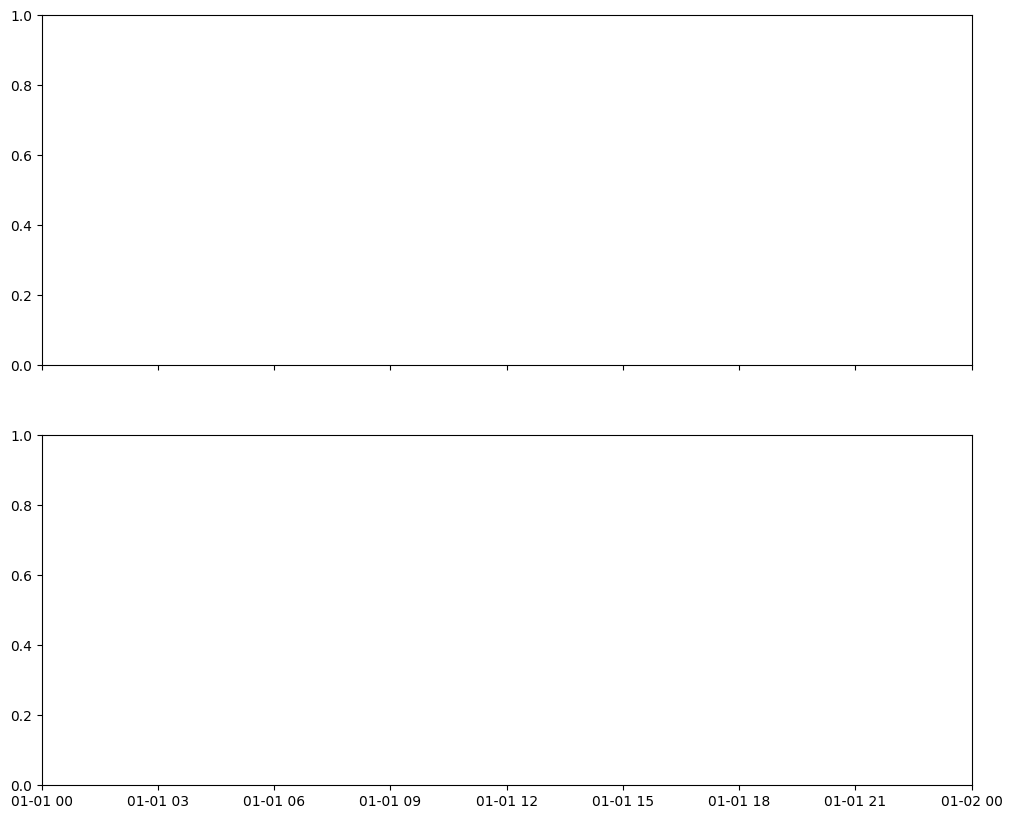

In [25]:
data = pd.read_csv("QRM-2025-cw2-data.csv", parse_dates=["Date"], index_col="Date")
data["log_return"] = 100 * np.log(data["TSLA"] / data["TSLA"].shift(1))
data = data.dropna()
data["loss"] = -data["log_return"]

split_date = "2021-11-26"

loss_train = data.loc[data.index < split_date, "loss"]
loss_test = data.loc[data.index >= split_date, "loss"]
dates_test = loss_train.index

# 2. Fit GARCH(1,1) on TRAINING Data Only
# ==========================================
# Define model on training data to estimate parameters
model_train = arch_model(loss_train, mean='Constant', vol='Garch', p=1, q=1, dist='Normal')
res_train = model_train.fit(disp='off')

# Extract standardized residuals from training for fitting t and EVT distributions
std_resid_train = res_train.std_resid.dropna()

# 3. Forecast Volatility for TEST Data
# ==========================================
# CRITICAL STEP: Create a new model using the FULL dataset
model_full = arch_model(data['loss'], mean='Constant', vol='Garch', p=1, q=1, dist='Normal')

# Apply the parameters estimated from the TRAINING set to the FULL set
# This filters the full history to generate conditional volatility for the test period
fixed_res = model_full.fix(res_train.params)

# Extract conditional volatility (sigma) only for the test period
sigma_test = fixed_res.conditional_volatility.loc[data.index < split_date]
mu_test = fixed_res.params['mu']

# 4. Calculate Quantiles (VaR_Z) and ES_Z for the Noise Z
# ==========================================
alphas = [0.95, 0.99]

# A. Standard Normal
norm_risk = {}
for alpha in alphas:
    q = norm.ppf(alpha)
    es = norm.pdf(q) / (1 - alpha)
    norm_risk[alpha] = {'VaR_Z': q, 'ES_Z': es}

# B. Normalized Student-t
# Fit t-distribution to standardized training residuals
nu_fit, t_loc, t_scale = t.fit(std_resid_train)

t_risk = {}
for alpha in alphas:
    q = t.ppf(alpha, df=nu_fit, loc=t_loc, scale=t_scale)
    # Calculate ES via numerical integration
    tail_expect = t.expect(lambda x: x, args=(nu_fit,), loc=t_loc, scale=t_scale, lb=q) / (1-alpha)
    t_risk[alpha] = {'VaR_Z': q, 'ES_Z': tail_expect}

# C. EVT (GPD)
# Fit GPD to excesses over threshold u (using training residuals)
u = 1.5
excesses = std_resid_train[std_resid_train > u] - u
xi_hat, _, beta_hat = genpareto.fit(excesses, floc=0)

N = len(std_resid_train)
Nu = len(excesses)

evt_risk = {}
for alpha in alphas:
    # Analytical VaR and ES formulas for GPD
    term = ((1 - alpha) / (Nu / N)) ** (-xi_hat) - 1
    var_z = u + (beta_hat / xi_hat) * term
    es_z = (var_z + beta_hat - xi_hat * u) / (1 - xi_hat)
    
    evt_risk[alpha] = {'VaR_Z': var_z, 'ES_Z': es_z}

# 5. Compute Dynamic VaR and ES for Test Set
# ==========================================
results = {0.95: {}, 0.99: {}}

for alpha in alphas:
    # Normal
    results[alpha]['Norm_VaR'] = mu_test + sigma_test * norm_risk[alpha]['VaR_Z']
    results[alpha]['Norm_ES']  = mu_test + sigma_test * norm_risk[alpha]['ES_Z']
    
    # Student-t
    results[alpha]['t_VaR'] = mu_test + sigma_test * t_risk[alpha]['VaR_Z']
    results[alpha]['t_ES']  = mu_test + sigma_test * t_risk[alpha]['ES_Z']
    
    # EVT
    results[alpha]['EVT_VaR'] = mu_test + sigma_test * evt_risk[alpha]['VaR_Z']
    results[alpha]['EVT_ES']  = mu_test + sigma_test * evt_risk[alpha]['ES_Z']

# 6. Plotting Results
# ==========================================
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for 95%
ax[0].plot(dates_test, loss_test, 'k.', markersize=3, label='Actual Loss', alpha=0.5)
ax[0].plot(dates_test, results[0.95]['Norm_VaR'], 'g-', label='Normal VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['t_VaR'], 'b-', label='Student-t VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['EVT_VaR'], 'r-', label='EVT VaR 95%', linewidth=1)
ax[0].plot(dates_test, results[0.95]['EVT_ES'], 'r:', label='EVT ES 95%', linewidth=1, alpha=0.7)
ax[0].set_title('95% Risk Forecasts (Test Data)')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Loss (%)')
ax[0].grid(True, alpha=0.3)

# Plot for 99%
ax[1].plot(dates_test, loss_test, 'k.', markersize=3, label='Actual Loss', alpha=0.5)
ax[1].plot(dates_test, results[0.99]['Norm_VaR'], 'g-', label='Normal VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['t_VaR'], 'b-', label='Student-t VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['EVT_VaR'], 'r-', label='EVT VaR 99%', linewidth=1)
ax[1].plot(dates_test, results[0.99]['EVT_ES'], 'r:', label='EVT ES 99%', linewidth=1, alpha=0.7)
ax[1].set_title('99% Risk Forecasts (Test Data)')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Loss (%)')
ax[1].grid(True, alpha=0.3)
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 7. Unconditional Coverage Backtest (Kupiec's Test)
# ==========================================
def kupiec_test(actual, var_forecast, alpha):
    T = len(actual)
    I = (actual > var_forecast).astype(int)
    x = I.sum() 
    p_hat = x / T 
    p = 1 - alpha 
    
    if x == 0: 
        return x, p_hat, 0.0, 0.0 
        
    ln_L0 = (T - x) * np.log(1 - p) + x * np.log(p)
    ln_L1 = (T - x) * np.log(1 - p_hat) + x * np.log(p_hat)
    LR = -2 * (ln_L0 - ln_L1)
    p_value = 1 - stats.chi2.cdf(LR, 1)
    
    return x, p_hat, LR, p_value

print(f"{'Model':<15} | {'Alpha':<5} | {'Violations':<10} | {'Rate (%)':<8} | {'LR Stat':<8} | {'P-Value':<8} | {'Result':<10}")
print("-" * 90)

models = ['Norm', 't', 'EVT']
for alpha in alphas:
    for m in models:
        var_col = f"{m}_VaR"
        x, p_hat, lr, p_val = kupiec_test(loss_test, results[alpha][var_col], alpha)
        res_str = "Reject" if p_val < 0.05 else "Accept"
        print(f"{m:<15} | {alpha:<5} | {x:<10} | {p_hat*100:<8.2f} | {lr:<8.2f} | {p_val:<8.4f} | {res_str:<10}")
    print("-" * 90)